In [38]:
import ast
import warnings
import textwrap

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

warnings.filterwarnings("ignore")

# For better visualizations
sns.set(style="ticks", palette="muted", color_codes=True)

plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.weight'] = 'bold'

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [39]:
def wrap_text(text):
    return textwrap.fill(text, width=85)

In [40]:
df=pd.read_csv("qatarairways_tweets_sentiments_with_keywords.csv", parse_dates=['date'])

In [41]:
df[['cleaned_text', 'yake_kw']].head(10).values

array([['fantastic service onboard impressed thank',
        'fantastic service,service onboard,onboard impressed,fantastic,service'],
       ['problem app not login account',
        'problem app,login account,problem,account,app'],
       ['report incident hope get resolution soon',
        'report incident,incident hope,report,incident,hope'],
       ['not settle due year appreciate emirates airways respect',
        'airways respect,settle due,due year,emirates airways,respect'],
       ['kindly communicate well upcoming rebooking',
        'kindly communicate,upcoming rebooking,kindly,rebooking,communicate'],
       ['not believe slowness cancel flight not inform try talk live chat happen wait minute unacceptable',
        'minute unacceptable,talk live,live chat,chat happen,happen wait'],
       ['unable log app try reset password not let proceed reset require character symbol etc check please need check flight',
        'unable log,check flight,character symbol,require character

In [42]:
df[['cleaned_text', 'keybert_kw']].head(10).values

array([['fantastic service onboard impressed thank',
        'onboard impressed,fantastic service,impressed thank,thank,service onboard'],
       ['problem app not login account',
        'not login,app not,problem app,problem,login account'],
       ['report incident hope get resolution soon',
        'resolution soon,get resolution,incident hope,report incident,incident'],
       ['not settle due year appreciate emirates airways respect',
        'airways respect,not settle,airways,due year,emirates'],
       ['kindly communicate well upcoming rebooking',
        'upcoming rebooking,rebooking,well upcoming,kindly,communicate'],
       ['not believe slowness cancel flight not inform try talk live chat happen wait minute unacceptable',
        'cancel flight,wait minute,talk live,unacceptable,flight'],
       ['unable log app try reset password not let proceed reset require character symbol etc check please need check flight',
        'reset password,password not,app try,need check,fli

In [43]:
df.loc[df['yake_kw'].str.contains("qatar", na=False)]

Empty DataFrame
Columns: [link, text, date, Likes, Comments, hashtags, users, cleaned_text, sntmnt_lbl, score, keybert_kw, yake_kw]
Index: []

In [44]:
df['keybert_kw'] = (
    df['keybert_kw']
    .apply(lambda x: ','.join([word for word in x.split(",") if 'qatar' not in word]))
)

In [45]:
df.loc[df['keybert_kw'].str.contains("qatar", na=False)]

Empty DataFrame
Columns: [link, text, date, Likes, Comments, hashtags, users, cleaned_text, sntmnt_lbl, score, keybert_kw, yake_kw]
Index: []

In [46]:
def get_kw_by_sentiment(sentiment, kw_col):

    kw = (
            df.loc[df[kw_col].ne('') & df['sntmnt_lbl'].eq(sentiment)]
            .loc[:, kw_col]
            .replace(" ", "_", regex=True)
            .replace(",", " ", regex=True)
            .str.cat(sep=" ")
    )

    return kw

In [47]:
from wordcloud import WordCloud

def create_wc(text_data, colormap=None):
    # Generate the word cloud
    wordcloud = WordCloud(width=1200, 
                          height=800,
                          colormap=colormap, 
                          background_color="black").generate(text_data)
    
    return wordcloud

In [48]:
def wordcloud_by_sentiment_and_keywordextractor(sentiment):

    kb_text = get_kw_by_sentiment(sentiment=sentiment, kw_col='keybert_kw')
    yake_text = get_kw_by_sentiment(sentiment=sentiment, kw_col='yake_kw')

    color_dict={'positive' : 'Greens',
                'negative' : 'YlOrRd',
                'neutral' : 'YlGnBu'}

    fig, axes = plt.subplots(1, 2, tight_layout=True, figsize=(15, 15))

    for text, title, ax in zip([kb_text, yake_text], 
                               ['keyBERT keywords', 'YAKE keywords'], 
                               axes.flatten()):
        
        wc = create_wc(text, colormap=color_dict[sentiment])
        ax.set_title(title)
        ax.imshow(wc, interpolation="bilinear")
        ax.axis("off")
        ax.grid(None)

    plt.show()

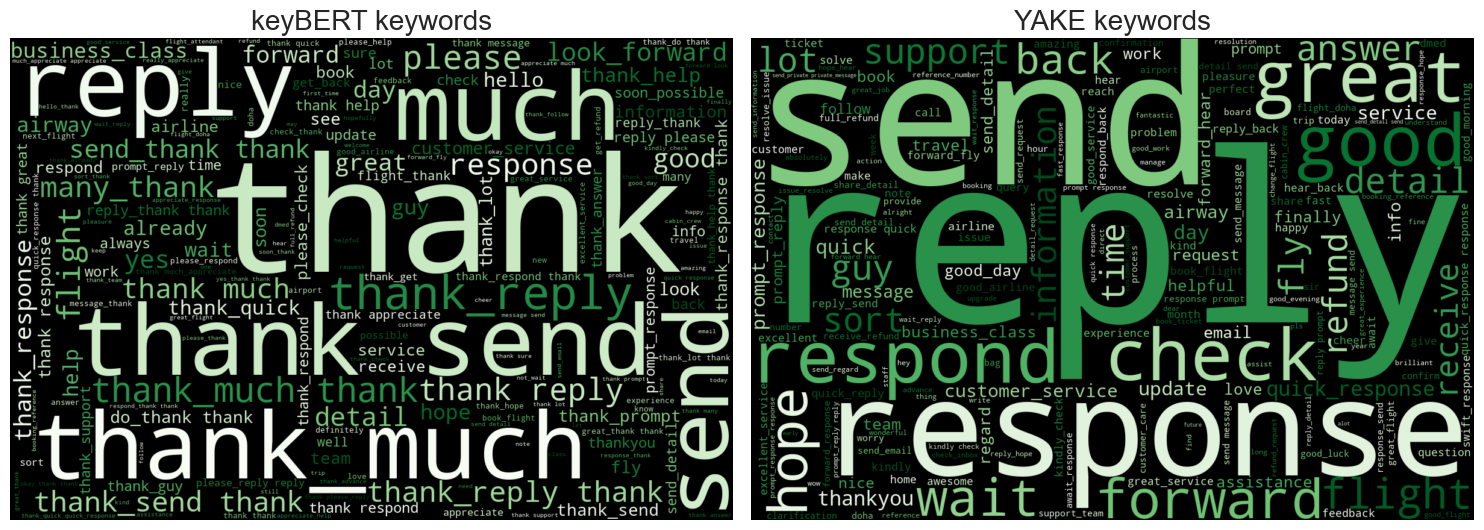

In [49]:
# Positive
wordcloud_by_sentiment_and_keywordextractor(sentiment='positive')

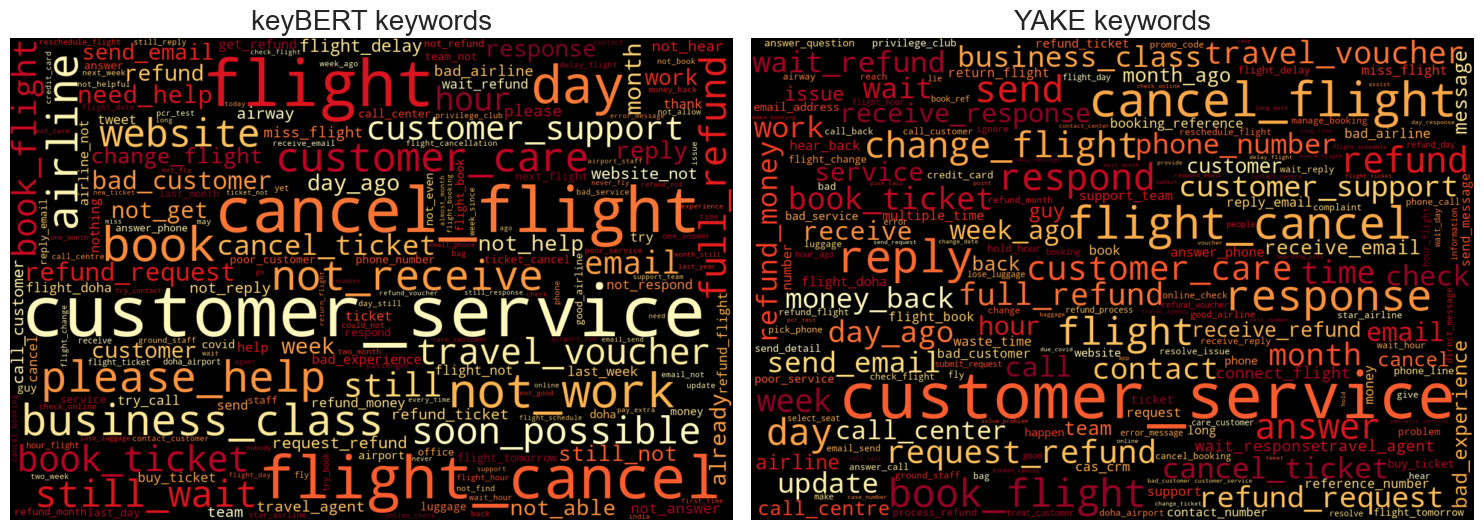

In [50]:
# Negative
wordcloud_by_sentiment_and_keywordextractor(sentiment='negative')

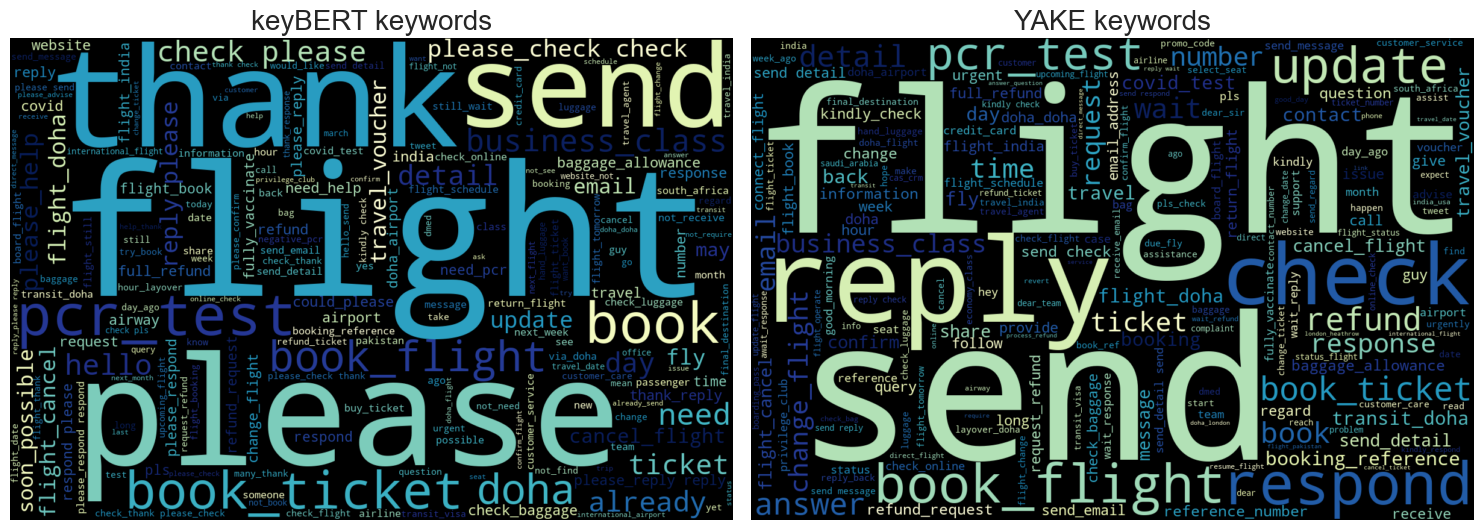

In [51]:
# Neutral
wordcloud_by_sentiment_and_keywordextractor(sentiment='neutral')

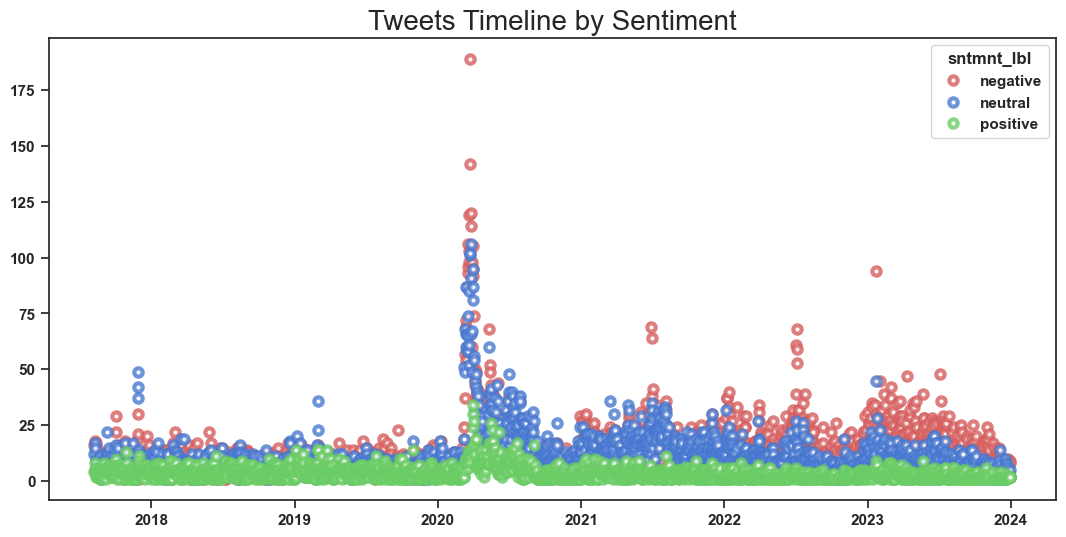

In [52]:
# Tweets Timeline
ax = (
    df.groupby([df['date'].dt.date, 'sntmnt_lbl']).size()
    .unstack('sntmnt_lbl')
    .plot(figsize=(13, 6), 
          linestyle='', 
          marker='o', 
          color=['r', 'b', 'g'], 
          alpha=0.8, 
          mfc='w', 
          markeredgewidth=3)
)

ax.set_title("Tweets Timeline by Sentiment")
ax.set_xlabel("");

In [82]:
(
    df.query("~yake_kw.isna()")
    .reset_index()
    .assign(keywords=lambda x: (x['keybert_kw']
                                .str
                                .cat(x['yake_kw'], sep=",")
                                .astype('string')))    
    .loc[:, 'keywords']
    .str.split(",")
    .apply(lambda x: len(x))
)

0        10
1        10
2        10
3        10
4        10
         ..
62190    10
62191    10
62192    10
62193    10
62194    10
Name: keywords, Length: 62195, dtype: int64

In [94]:
df = (
    df.query("~yake_kw.isna()")
    .reset_index(drop=True)
    .assign(keywords=lambda x: (x['keybert_kw']
                                .str
                                .cat(x['yake_kw'], sep=",")
                                .astype('string')
                                .str.split(",")
                                .apply(lambda x: ','.join(set(x)))))    
)

In [95]:
def top_20_kw_strings(kw):
    
    # Create Top 20 keyword series
    ################################
    query=f"""
        keywords!='' and sntmnt_lbl in ('negative', 'positive')
    """

    kw_df = (
        # Filter rows with no strings and with +ve and -ve sentiments only
        df.query(query)

        # split all keywords of each row to lists
        .assign(keywords=lambda x: x['keywords'].str.split(","))

        # convert to only 1 keyword per row
        .explode(column='keywords')

        .assign(keywords=lambda x: x['keywords'].astype('string'))

        # filter out rows with the required keyword
        .query(f"keywords.str.contains('{kw}')")

        # assign a column with value 1, so that it can be summed during aggregation
        .assign(count=1)

        # group by keywords and get count of +ve and -ve sentiments
        .groupby(['keywords', 'sntmnt_lbl'])['count'].sum()

        # pivot sentiment column
        .unstack('sntmnt_lbl')

        # Some keywords may have only -ve category (or vice versa). 
        # If so, create a new column for the missing sentiment with value 0
        .assign(negative=lambda x: x['negative'] if 'negative' in x.columns else 0,
                positive=lambda x: x['positive'] if 'positive' in x.columns else 0)

        # convert to integer data type and create new column that has total of -ve and +ve
        .assign(negative=lambda x: x['negative'].astype("Int64"),
                positive=lambda x: x['positive'].astype("Int64"),
                total=lambda x: x['negative'] + x['positive'])

        # select only the top 20 by total
        .nlargest(20, columns='total')

        # drop total column
        .drop('total', axis=1)

        # Ensure the columns are of this order
        .reindex(columns=['negative', 'positive'])
    )

    return kw_df

In [96]:
def kw_sntmnt_timeline(kw):
    
    # Create keyword frequncy timeline
    ##################################
    
    start=df['date'].dt.date.min()
    end=df['date'].dt.date.max()

    tl_df = (   
        # query rows with required keyword and filter out rows with neutral sentiment
        df.query(f"keywords.str.contains('{kw}') and sntmnt_lbl!='neutral'")

        # create new column containing date value
        # This is useful during aggregating by date and getting count of keyword per day
        .assign(only_date=lambda x: pd.to_datetime(x['date'].dt.date))

        # group by date and sentiment label and get count
        .groupby(['only_date', 'sntmnt_lbl']).size()

        # pivot sentiment col
        .unstack('sntmnt_lbl')
        
        # Some keywords may have only -ve category (or vice versa). 
        # If so, create a new column for the missing sentiment with value null
        .assign(negative=lambda x: x['negative'] if 'negative' in x.columns else np.nan,
                positive=lambda x: x['positive'] if 'positive' in x.columns else np.nan)

        # Ensure date range is from aug 2017 to dec 2023 and ensure right order of columns
        .reindex(pd.date_range(start, end), columns=['negative', 'positive'])

        # convert to integer data type and create new column
        .assign(negative=lambda x: x['negative'].astype("Int64"),
                positive=lambda x: x['positive'].astype("Int64"))
    )

    return tl_df

In [97]:
def get_ht_sntmnt_from_kw(kw):
    
    # dataframe with concatenated hastags by sentiments
    ht_df = (
        df.query(f"keywords.str.contains('{kw}') and hashtags!='[]' and sntmnt_lbl!='neutral'")
        .loc[:, ['sntmnt_lbl', 'hashtags']]
        .assign(hashtags=lambda x: x['hashtags'].apply(ast.literal_eval))
        .explode(column='hashtags')
        .assign(hashtags=lambda x: x['hashtags'].str.lower())
        .loc[lambda x: ~x['hashtags'].isin(['#qatarairways', '#qatar', '#qrsupport'])]
        .loc[lambda x: ~x['hashtags'].str.contains(r'^#[0-9]+$')]
        .groupby('sntmnt_lbl')['hashtags'].agg(lambda x: ' '.join(x))
    )

    # Negative hashtag
    try:
        neg_ht = ht_df.loc[lambda x: x.index=='negative'].values[0]
    except IndexError:
        neg_ht = 'no_hashtag'

    # Positive hashtag
    try:
        pos_ht = ht_df.loc[lambda x: x.index=='positive'].values[0]
    except IndexError:
        pos_ht = 'no_hashtag'

    return neg_ht, pos_ht

In [98]:
def analyze_kw(kw):

    # https://www.geeksforgeeks.org/how-to-create-different-subplot-sizes-in-matplotlib/

    fig = plt.figure()
    fig.set_figheight(7.8)
    fig.set_figwidth(12)

    ax0 = plt.subplot2grid(shape=(2, 4), loc=(0, 0))
    ax1 = plt.subplot2grid(shape=(2, 4), loc=(0, 1), colspan=3)
    ax2 = plt.subplot2grid(shape=(2, 4), loc=(1, 0), colspan=2)
    ax3 = plt.subplot2grid(shape=(2, 4), loc=(1, 2), colspan=2)

    # Colors for sentiment
    color=['r', 'green']

    # Create Top 20 keyword Bargraph
    ################################

    subplot_title="" if len(kw)>25 else kw

    top_20_kw_strings_df = top_20_kw_strings(kw=kw)

    # Plot bargraph
    top_20_kw_strings_df.plot(kind='barh', 
                                stacked=True, 
                                edgecolor='k', 
                                ax=ax0, 
                                color=color, 
                                legend=None)

    ax0.set_title(f"kw: '{subplot_title}'")

    # Create keyword frequncy timeline
    ##################################

    kw_sntmnt_timeline_df = kw_sntmnt_timeline(kw=kw)

    kw_sntmnt_timeline_df.plot(ax=ax1, 
                            linestyle="", 
                            marker='.', 
                            alpha=0.7, 
                            color=color, 
                            legend=None)

    ax1.set_title(f"Keyword '{subplot_title}' timeline")
    ax1.set_xlabel("")
    
    max_ylim=kw_sntmnt_timeline(kw).max().max()

    if  max_ylim < 10: 
        ax1.set_ylim(0, 10)
        ax1.set_yticks(range(0, 12, 2))

    # Highlighting Qatar flight ban time period
    # ax1.fill_between(x=("2020-03-18", "2020-04-01"), y1=0, y2=max_ylim+2, color='b', alpha = 0.5)

    # Hashtag Worldclouds by sentiment
    ##################################
    
    neg_ht, pos_ht = get_ht_sntmnt_from_kw(kw)

    for ht, ax, cmap, title in zip([neg_ht, pos_ht],
                             [ax2, ax3],
                             ['YlOrRd', 'Greens'],
                             ["#negativehastags", "#positivehashtags"]):

        wordcloud = WordCloud(width=600, height=350, colormap=cmap).generate(ht)
        
        ax.set_title(title)
        ax.imshow(wordcloud, interpolation="bilinear")
        ax.axis("off")
        ax.grid(None)
        

    labels=['negative', 'positive']
    fig.legend(labels, loc='center', bbox_to_anchor=(0.88, 0.92), ncol=len(labels), 
               bbox_transform=fig.transFigure)

    plt.tight_layout()
    plt.show()

In [99]:
# top keywords

(
    df['keywords']
    .str.split(",")
    .explode()
    .str.split()
    .explode()
    .value_counts()
    .nlargest(20)
)

keywords
flight      26223
not         12473
thank       10349
refund      10149
send         8735
reply        8385
ticket       8249
customer     7862
book         7628
check        7182
please       7064
doha         6974
day          6515
email        6432
travel       6376
response     5876
cancel       5697
service      5449
time         5056
hour         5006
Name: count, dtype: int64

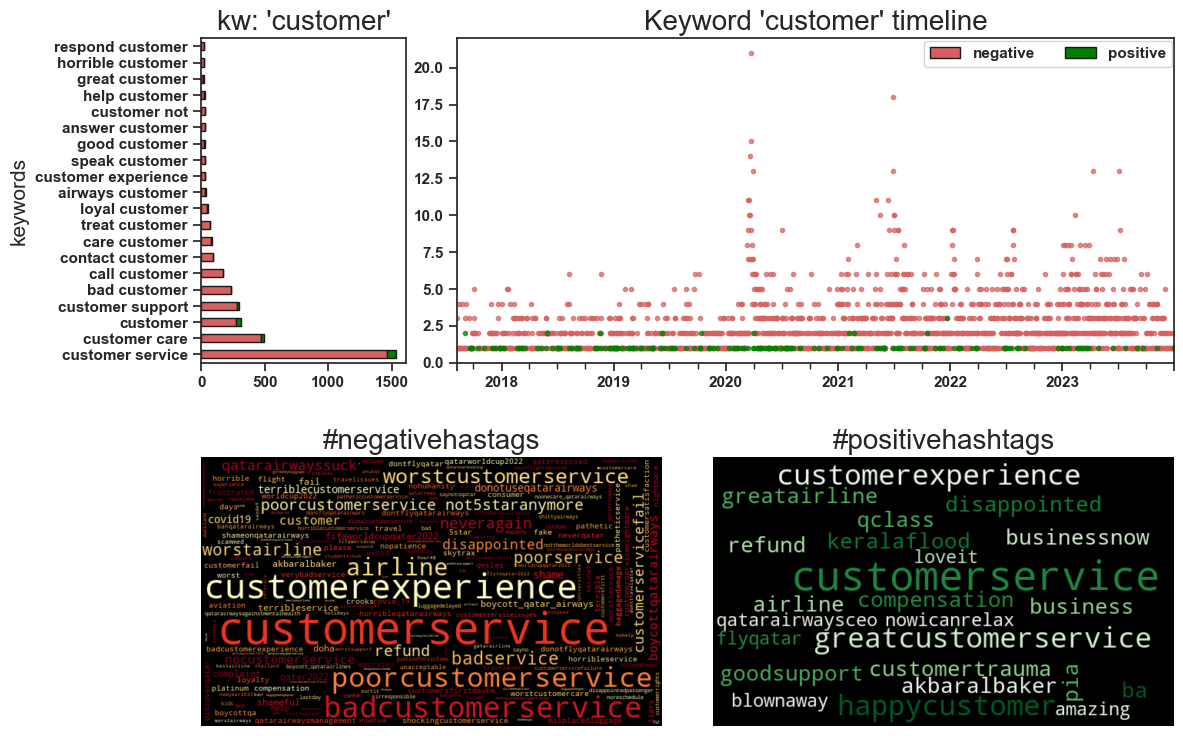

In [100]:
analyze_kw(kw='customer')

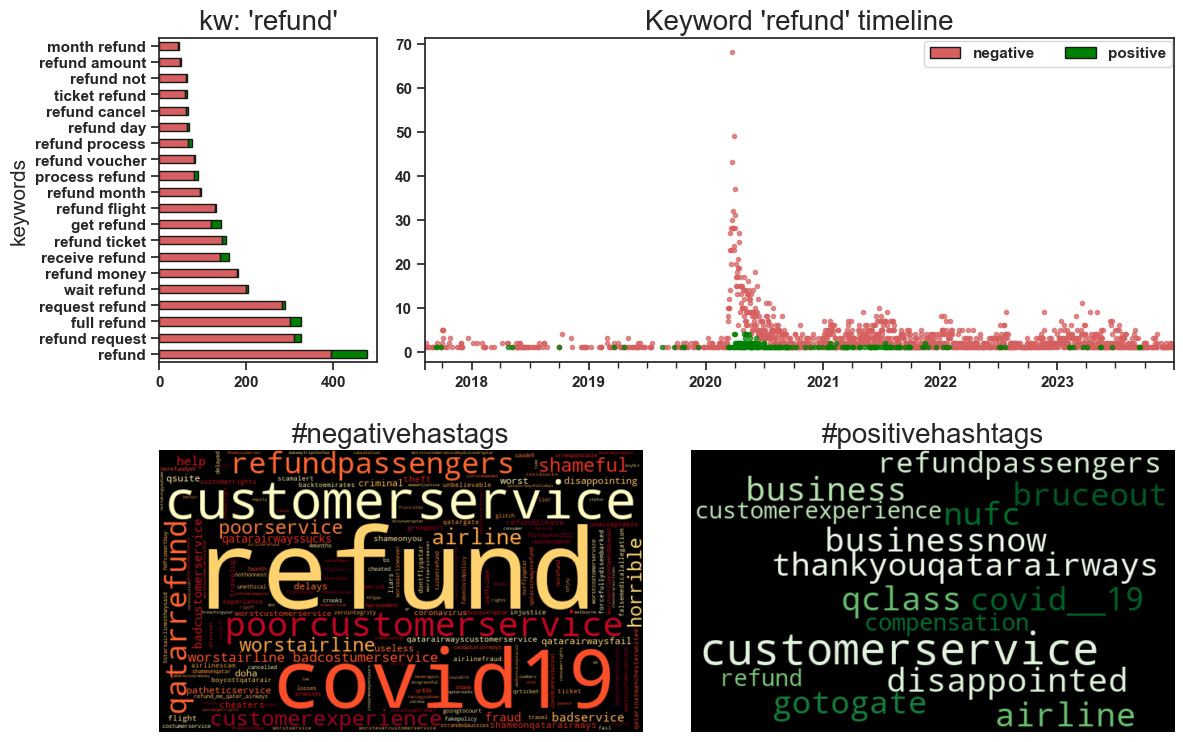

In [101]:
analyze_kw(kw='refund')

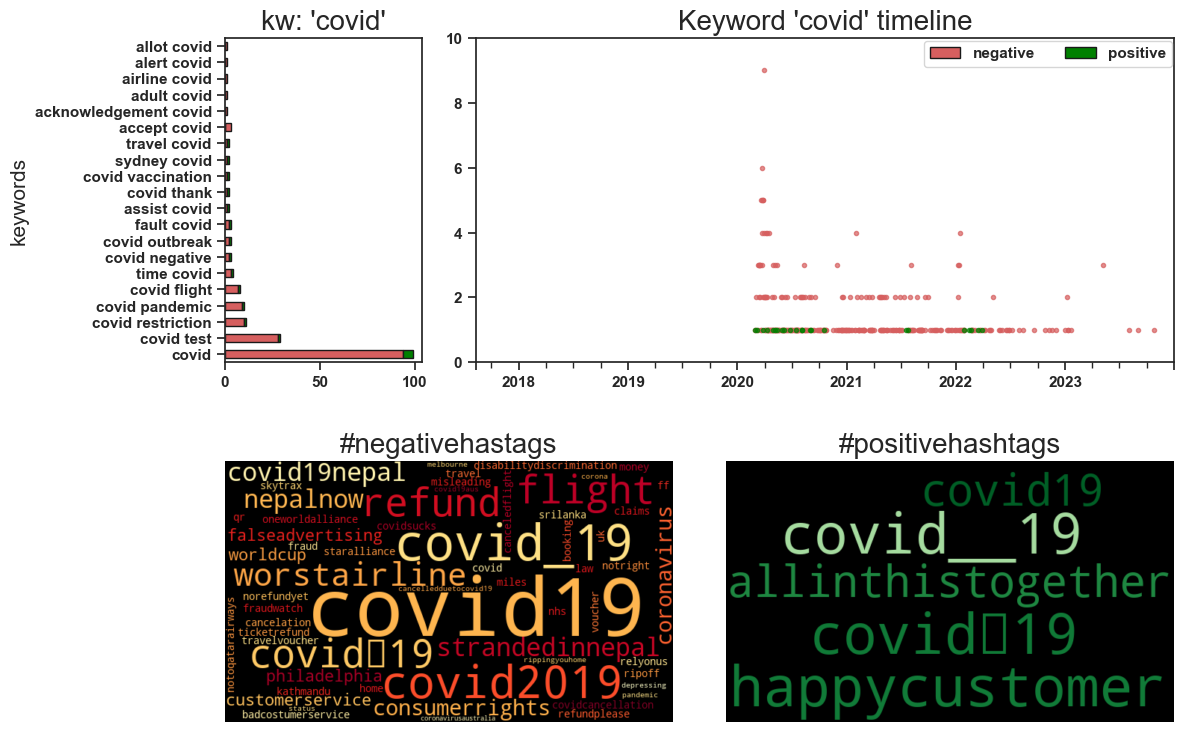

In [102]:
analyze_kw(kw='covid')

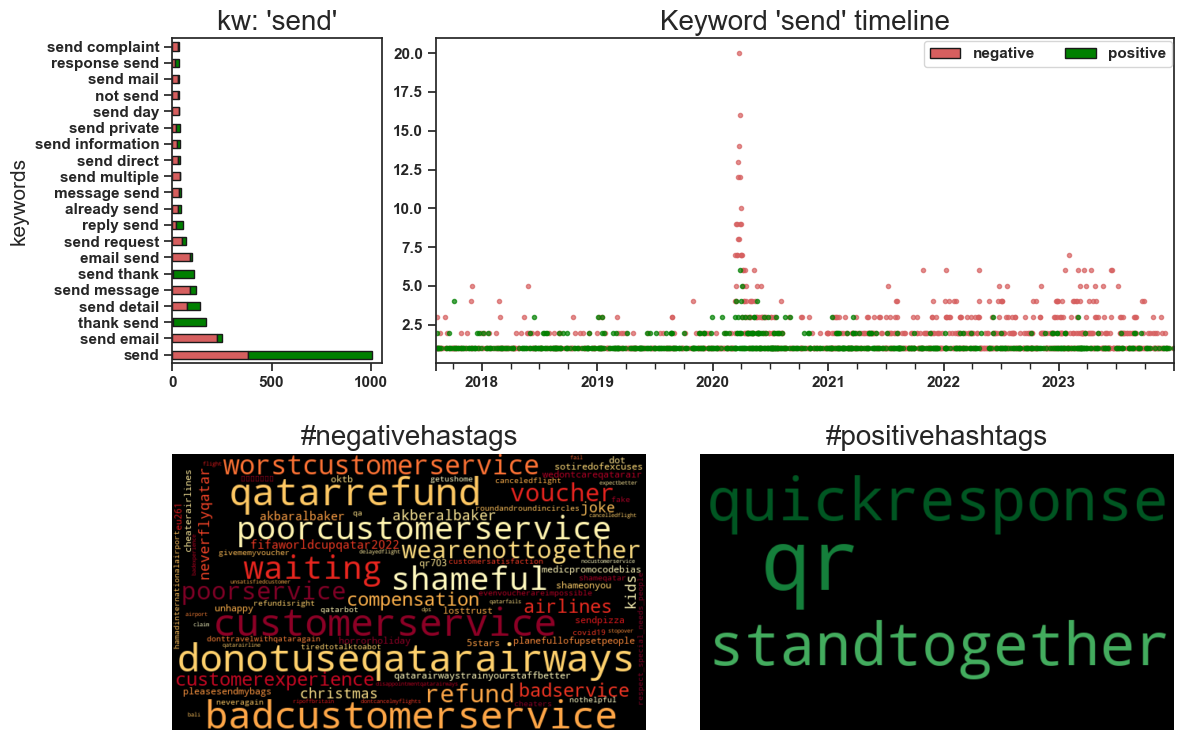

In [103]:
analyze_kw(kw='send')

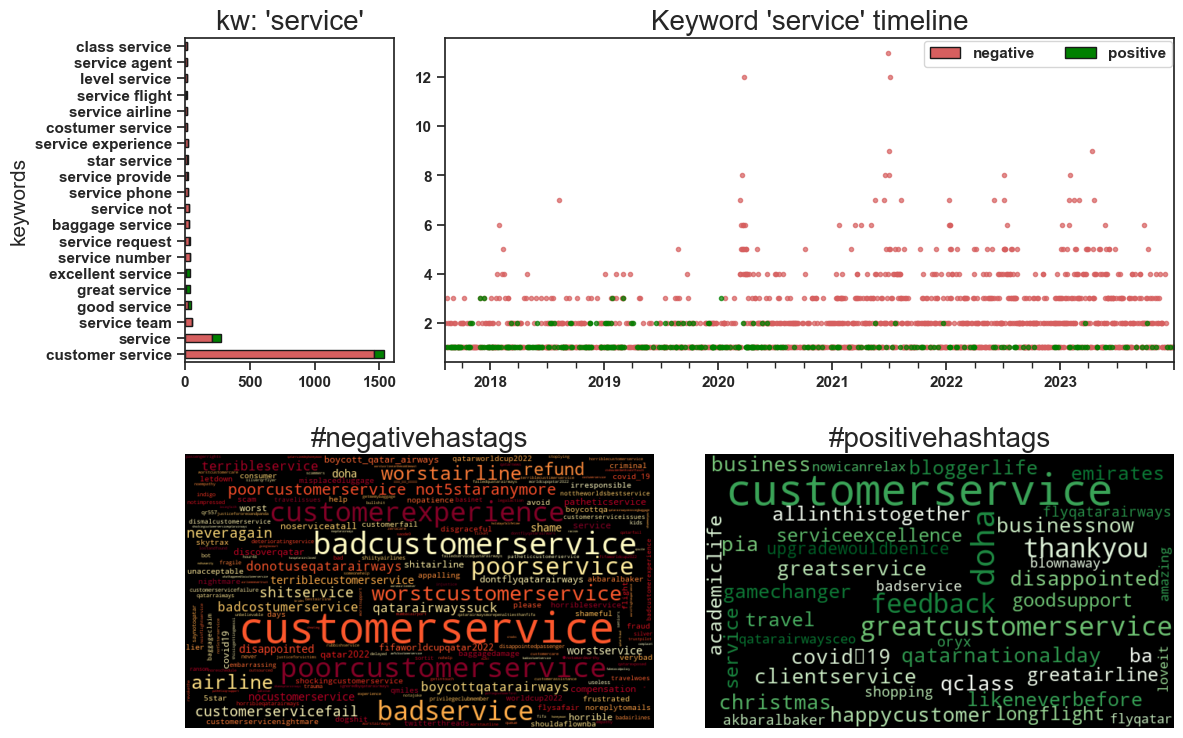

In [104]:
analyze_kw(kw='service')

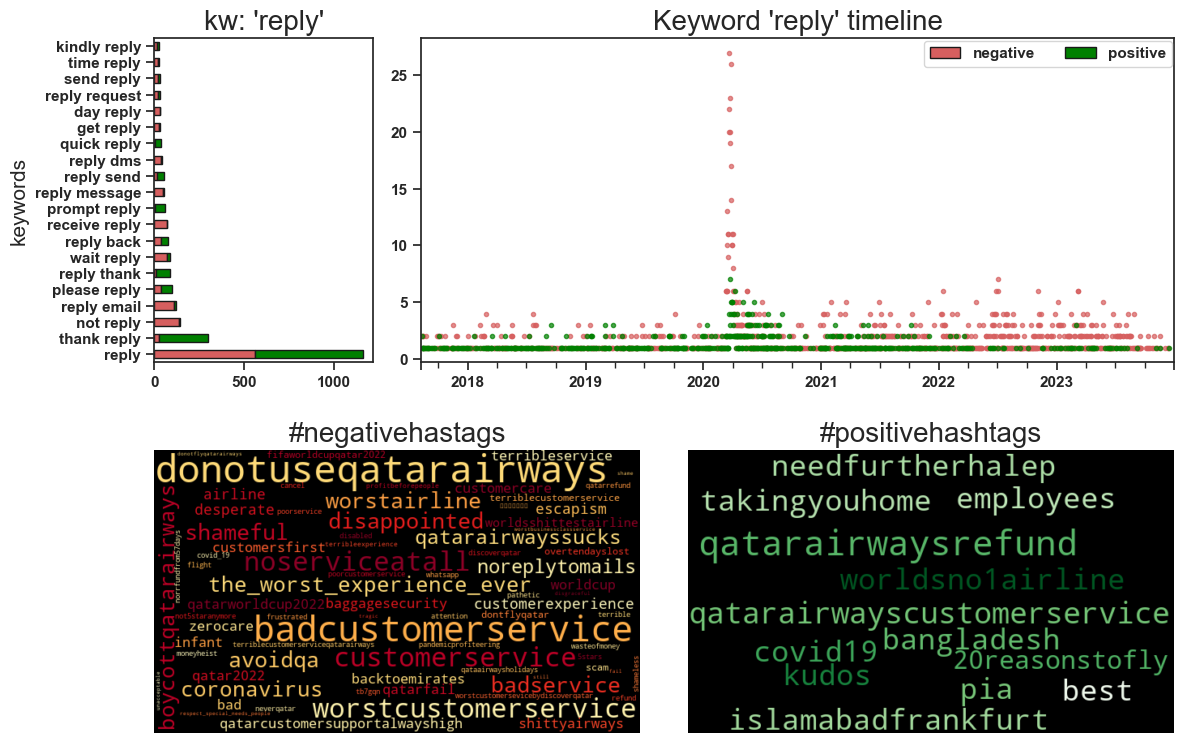

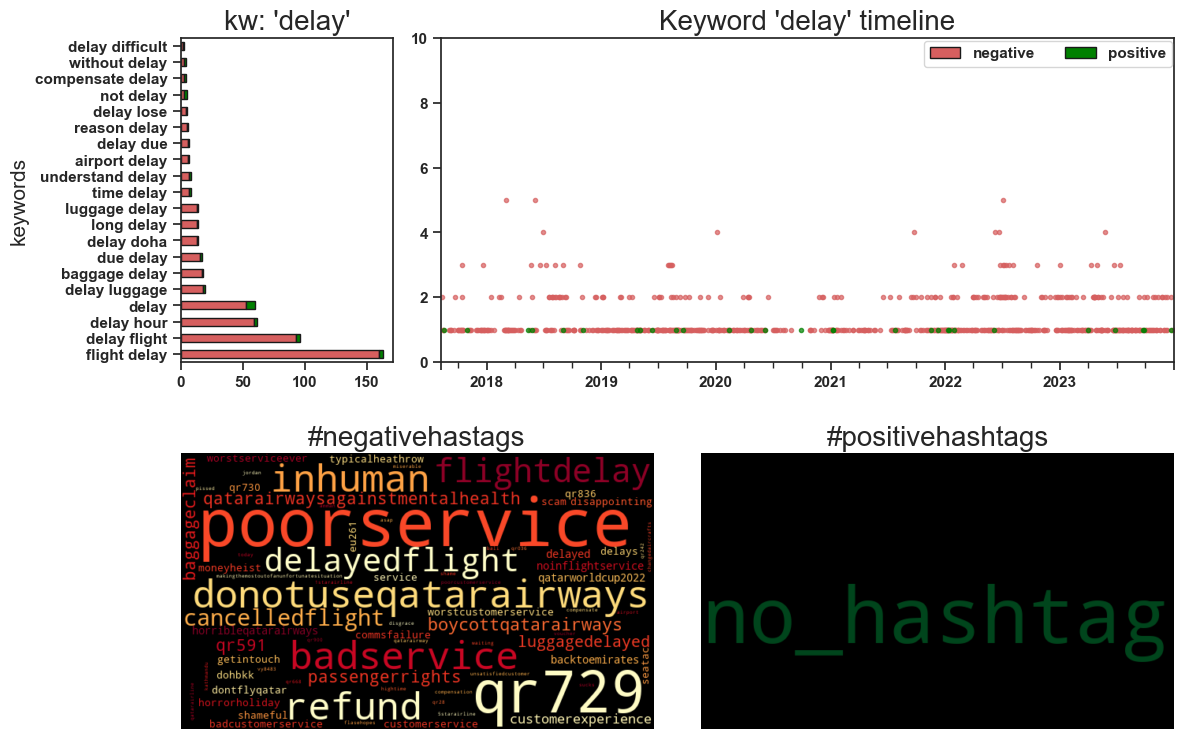

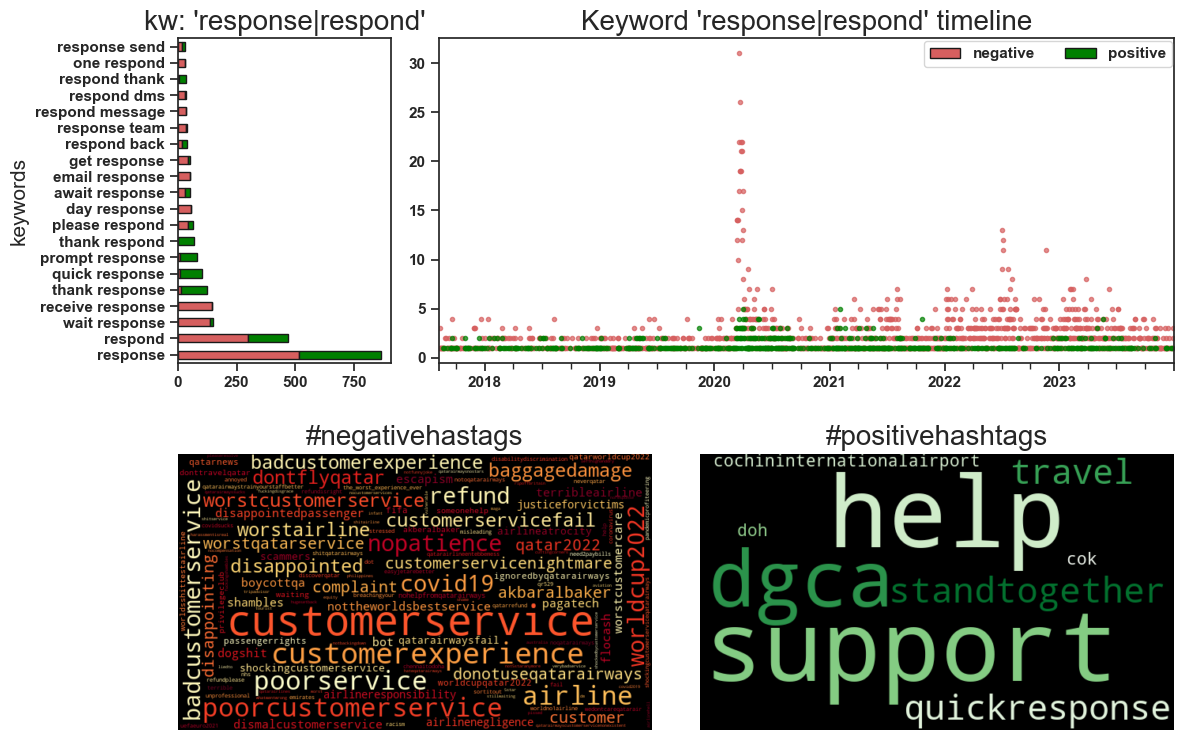

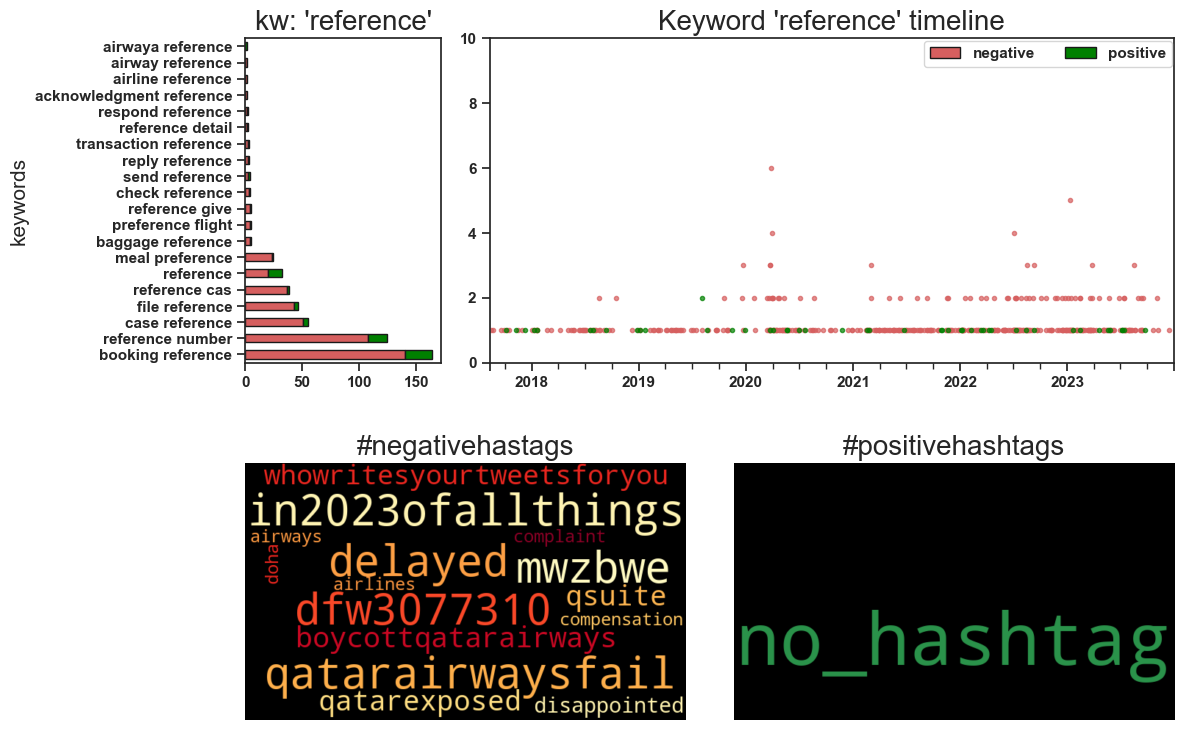

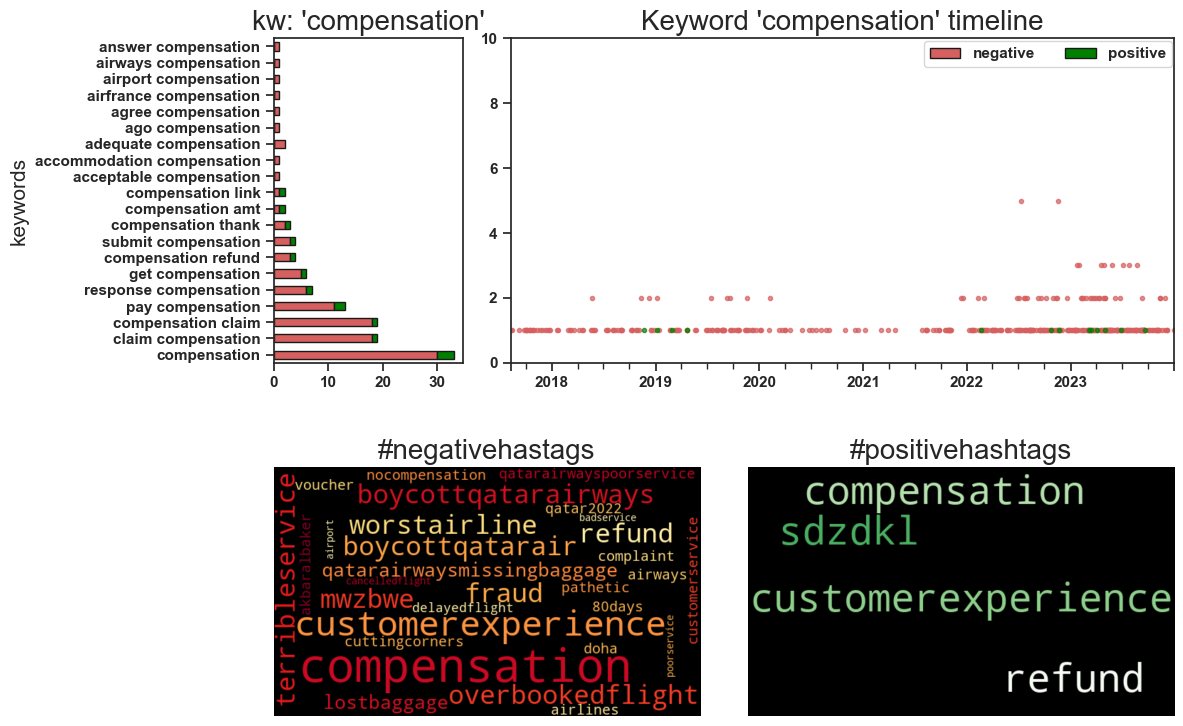

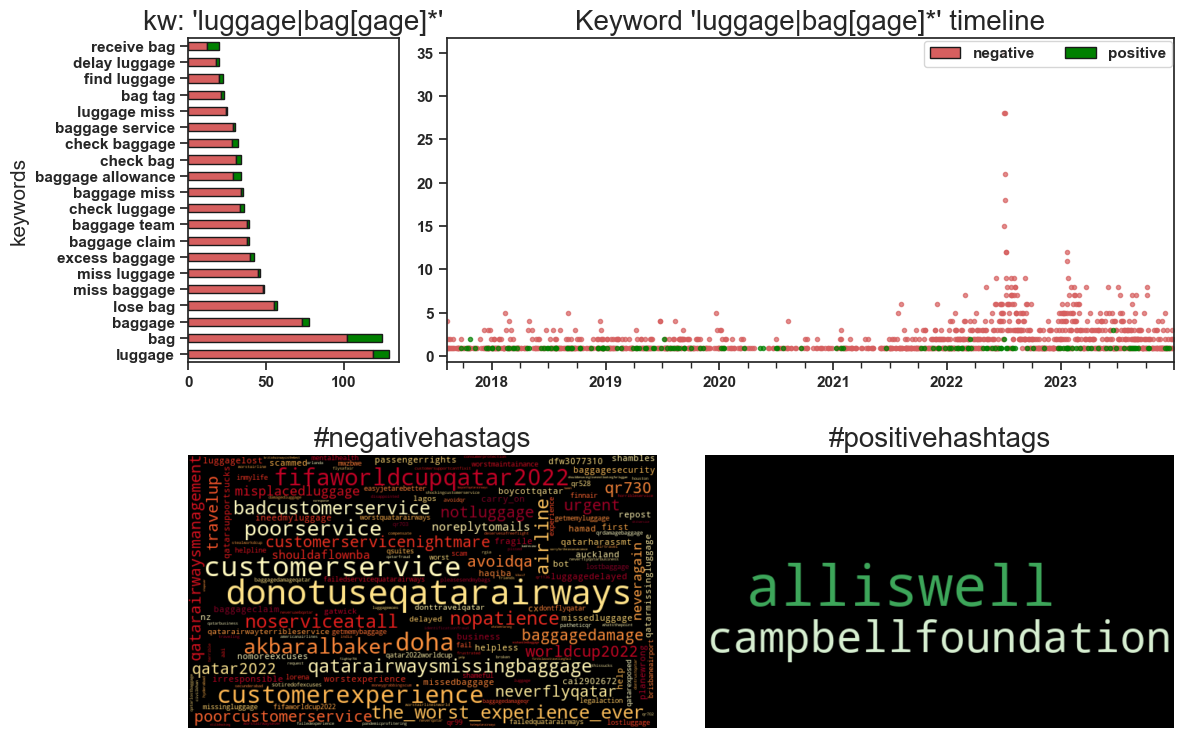

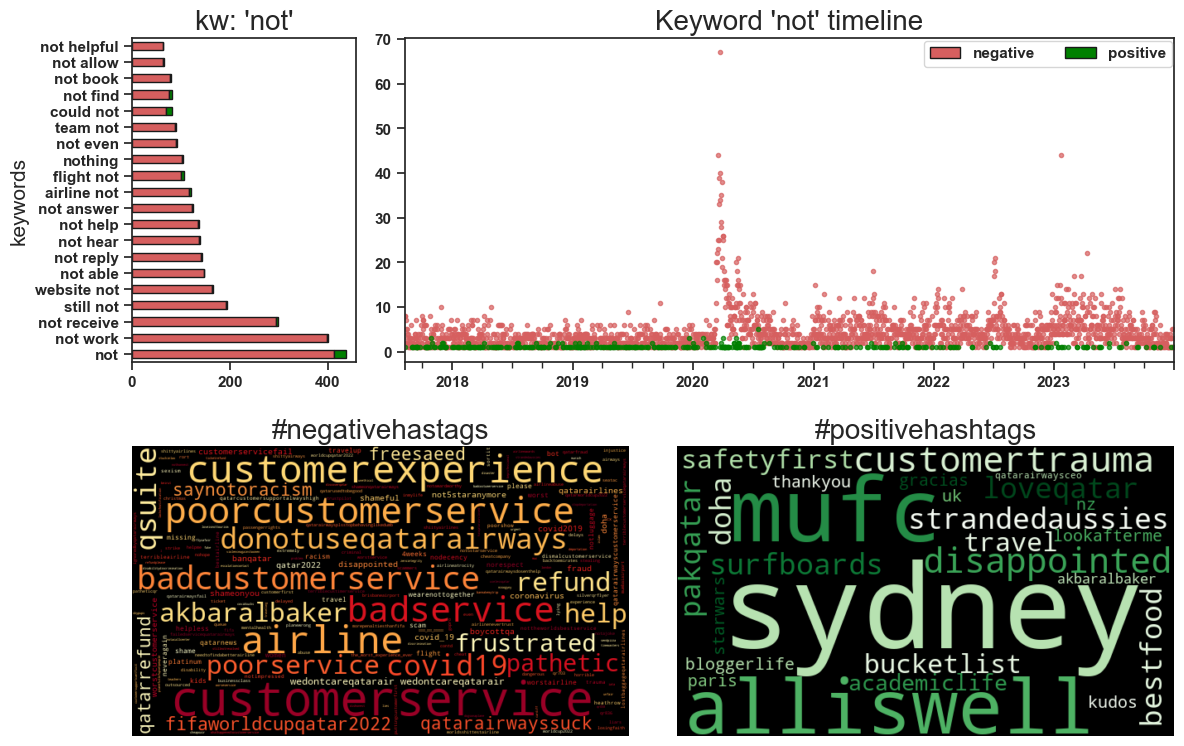

In [105]:
analyze_kw(kw='reply')
analyze_kw(kw='delay')
analyze_kw(kw='response|respond')
analyze_kw(kw='reference')
analyze_kw(kw='compensation')
analyze_kw(kw='luggage|bag[gage]*')
analyze_kw(kw='not')


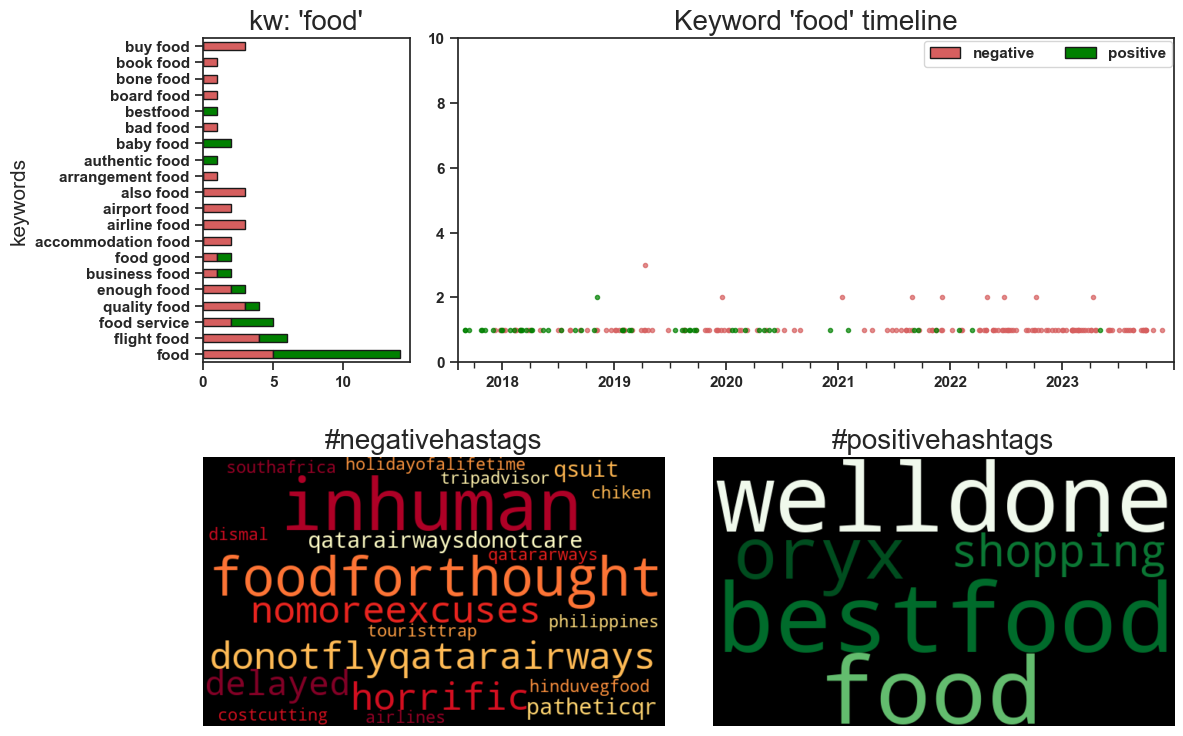

In [106]:
analyze_kw(kw='food')

In [107]:
(
    df.query("cleaned_text.str.contains('disappoint', case=False) and sntmnt_lbl=='positive'")
    .loc[:, 'text']
    .values
)

array(['@qrsupport thank you Qatar for keeping your promise and refunding me. Waiting times can be really long and make your clients get disappointed but I’m glad I finally made it! Thank you indeed',
       'Thank you for replying after 300 years. I’ll be ever more grateful if you refunded my money. Your customer service isn’t really doing your customers any service at all. #Disappointed',
       "Hi @qrsupport, I have sent you a DM. Some of us we are real fans of your airline and the top-nocht service. A couple of friends are on my same situation and as far as I see other Tweeter users. Please, don't disappoint us by being passive or unfair. Be splendid again!",
       'Dear @qatarairways indeed you took a good care of me. I love flying with you and you never disappoint. However Ricardo service today was exceptional .. I am sending you details as requested.',
       'pretty soon in 2 weeks time. QR579 / 729 QR708/ 578 729 is my fav just b,cause of awesome @airbus #A350 so kind of dis

In [108]:
# This tweet is supposed to be of negative sentiment
print(
    wrap_text(
        df.query("hashtags.str.contains('disappoint', case=False) and sntmnt_lbl=='positive'")
        .loc[:, 'text']
        .values[0]
    )
)

Thank you for replying after 300 years. I’ll be ever more grateful if you refunded my
money. Your customer service isn’t really doing your customers any service at all.
#Disappointed


# Users
#### Analyzing those tweets by a users that tweeted the most in a single day

In [109]:
def analyze_usertweets_by_date(user, date):

    end_of_date=(pd.Timedelta('1D') + pd.to_datetime(date)).strftime('%Y-%m-%d')

    text_data=(
        df.loc[df['date'].between(date, end_of_date) & df['users'].eq(user)]
        .sort_values('date')
        .loc[:, 'keywords']
        .str.split(",")
        .explode()
        .replace(" ", "_", regex=True)
        .str.cat(sep=" ")
    )

    wc = create_wc(text_data)

    plt.figure(figsize=(15, 6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.grid(None)
    plt.show()

In [110]:
# Getting list of users that tweeted the most in a single day with their 
# tweet count for that day
(
    df.assign(only_date=lambda x: x['date'].dt.date)
    .groupby(['only_date', 'users']).size()
    .to_frame('tweet_count')
    .reset_index()
    .assign(tweet_count_rank=lambda x: (x.groupby('only_date')['tweet_count']
                                        .rank('dense', ascending=False)
                                        .astype(int)))
    .loc[lambda x: x['tweet_count_rank'].eq(1)]
    .drop('tweet_count_rank', axis=1)
    .nlargest(10, columns='tweet_count')    
)

only_date            users  tweet_count
776    2017-10-02  KiranKu78839646           25
10710  2019-09-22   shiraz_shafqat           23
1338   2017-11-16           HT4599           18
24426  2020-11-01    stevesukkie93           18
15089  2020-03-25         Leo_P999           16
3590   2018-04-27         hamzag22           15
42424  2023-01-03      LaverdeCaro           15
3577   2018-04-26         hamzag22           14
44167  2023-03-16   TanyaT55736757           14
46151  2023-07-05        krupamaya           14

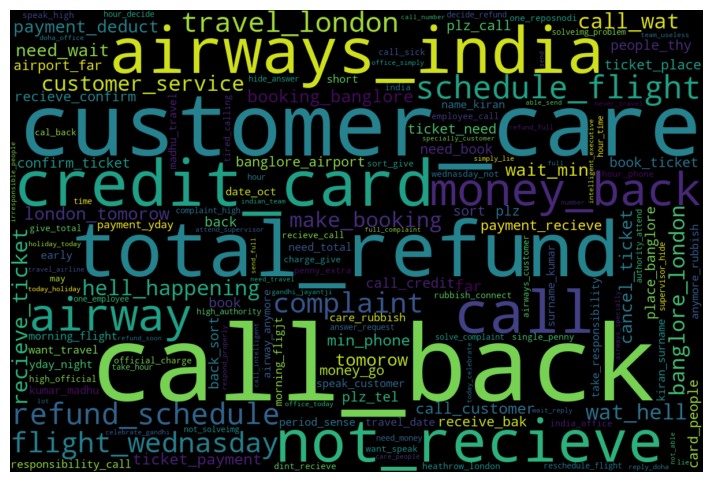

In [111]:
user='KiranKu78839646'
date='2017-10-02'

analyze_usertweets_by_date(user, date)

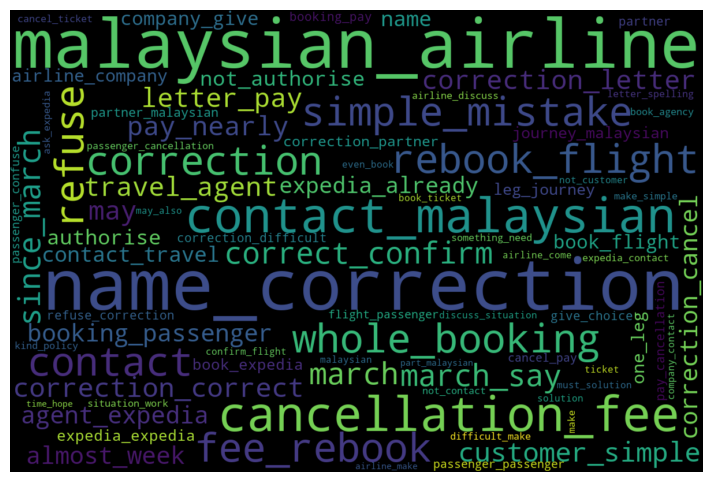

In [112]:
user='TanyaT55736757'
date='2023-03-16'

analyze_usertweets_by_date(user, date)

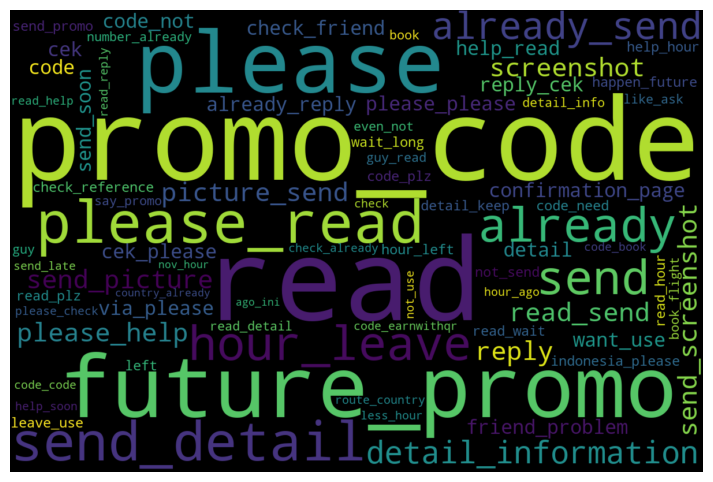

In [113]:
user='stevesukkie93'
date='2020-11-01'

analyze_usertweets_by_date(user, date)

# Topic Modeling

In [114]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

sentence_model = SentenceTransformer("all-mpnet-base-v2")
topic_model = BERTopic(embedding_model=sentence_model)

In [115]:
docs = df['cleaned_text']
topics, probs = topic_model.fit_transform(docs)

In [116]:
topic_model.get_topic_info()

Topic  Count                                         Name  \
0       -1  26186                -1_customer_not_ticket_flight   
1        0   3388              0_baggage_bag_luggage_allowance   
2        1   1952                  1_refund_bank_money_process   
3        2   1670                    2_test_pcr_covid_negative   
4        3   1463            3_refund_qatar_airway_qatarairway   
..     ...    ...                                          ...   
522    521     10                  521_puq_bharani_nhb_beacuse   
523    522     10            522_patient_lawsuit_produce_alive   
524    523     10                   523_update_follow_news_hrs   
525    524     10  524_sweetie_sweetheart_timeline_approximate   
526    525     10             525_cpt_vaccation_ankra_flighing   

                                        Representation  \
0    [customer, not, ticket, flight, time, book, se...   
1    [baggage, bag, luggage, allowance, carry, piec...   
2    [refund, bank, money, process, month, request,...   
3    [test, pcr, covid, negative, require, vaccinat...   
4    [refund, qatar, airway, qatarairway, airways, ...   
..                                                 ...   
522  [puq, bharani, nhb, beacuse, neck, sar, favor,...   
523  [patient, lawsuit, produce, alive, falsely, vi...   
524  [update, follow, news, hrs, hour, kind, promis...   
525  [sweetie, sweetheart, timeline, approximate, s...   
526  [cpt, vaccation, ankra, flighing, vist, sand, ...   

                                   Representative_Docs  
0    [impossible reach not give option free cancell...  
1    [check ticket baggage allowance, thank mean ca...  
2    [inform april refund process not get anything ...  
3    [case cancel flight need take pcr test, pcr te...  
4    [follow refund last month still response qatar...  
..                                                 ...  
522  [also not refund beacuse book long time back g...  
523  [already keep say price fix know want help com...  
524  [tell follow hour hope news, request follow hr...  
525  [please share timeline, thank reply much appre...  
526  [good luck show make send private message get ...  

[527 rows x 5 columns]

In [117]:
df = (
    df.assign(topics=topics)
    .merge(topic_model.get_topic_info()[['Topic', 'Name']], 
             how='left',
             left_on='topics',
             right_on='Topic')
    .drop(['Topic', 'topics'], axis=1)
    .rename(columns={'Name': 'topic_name'})
)

df.head(3)

link  \
0  https://twitter.com/juliet_gough/status/174158...   
1  https://twitter.com/theamaeestales/status/1741...   
2  https://twitter.com/rvvaradan/status/174143019...   

                                                text  \
0  It was fantastic service onboard. I'm so impre...   
1  @qrsupport is there a problem with your app? I...   
2  I have reported the incident. Hoping to get a ...   

                       date  Likes  Comments hashtags           users  \
0 2023-12-31 22:23:00+00:00      0         0       []    juliet_gough   
1 2023-12-31 19:51:00+00:00      0         0       []  theamaeestales   
2 2023-12-31 12:04:00+00:00      1         3       []       rvvaradan   

                                cleaned_text sntmnt_lbl     score  \
0  fantastic service onboard impressed thank   positive  0.989524   
1              problem app not login account   negative  0.781741   
2   report incident hope get resolution soon    neutral  0.689427   

                                          keybert_kw  \
0  onboard impressed,fantastic service,impressed ...   
1  not login,app not,problem app,problem,login ac...   
2  resolution soon,get resolution,incident hope,r...   

                                             yake_kw  \
0  fantastic service,service onboard,onboard impr...   
1      problem app,login account,problem,account,app   
2  report incident,incident hope,report,incident,...   

                                            keywords  \
0  fantastic service,thank,fantastic,service onbo...   
1  app not,not login,account,problem app,problem,...   
2  report,incident,incident hope,get resolution,r...   

                              topic_name  
0  23_crew_amazing_excellent_comfortable  
1          -1_customer_not_ticket_flight  
2     21_complaint_raise_formal_complain

In [118]:
(
    df['topic_name'].value_counts()
    .nlargest(20)
)

topic_name
-1_customer_not_ticket_flight           26186
0_baggage_bag_luggage_allowance          3388
1_refund_bank_money_process              1952
2_test_pcr_covid_negative                1670
3_refund_qatar_airway_qatarairway        1463
4_call_phone_number_hold                 1150
5_bag_baggage_luggage_lose                685
6_seat_select_selection_choose            646
7_change_date_reschedule_schedule         595
8_refund_cancel_request_full              570
9_fly_tomorrow_forward_soon               484
10_qatar_arabia_saudi_support             455
11_name_passport_middle_surname           449
12_cancel_cancellation_flight_option      415
13_upgrade_business_class_offer           338
14_pakistan_lahore_islamabad_karachi      325
15_meal_preference_food_vegetarian        318
16_tweet_twitter_ignore_retweet           318
17_australia_sydney_melbourne_perth       310
18_transit_visa_doha_indian               299
Name: count, dtype: int64

In [119]:
df.to_csv('qatarairways_tweets_sentiments_with_keywords_topics.csv', index=False)